# DQN
1. 단일계층 네트워크를 다계층 합성곱 네트워크로 확장
2. 경험 리플레이의 구현
    - 즉, 네트워크가 자신의 경험에 저장된 기억을 이용해 스스로 학습
    - 에이전트의 경험을 저장해두었다가, 랜덤하게 경험의 일부를 뽑아서 네트워크를 학습시킴
        - robust
        - 랜덤하게 뽑는 경험 => 다양한 과거 경험으로부터 학습가능
    - 각 경험은 (상태, 액션, 보상, 다음상태)의 튜플
3. 제 2의 타깃 네트워크를 활용하여 업데이트 시 target Q 값을 계산
    - 학습시 모든 액션에 대한 비용을 계산하기 위해 이용되는 target Q값을 생성함
    - 즉, 예측하는 네트워크(predict Q)랑 조절하는 네트워크(target Q)랑 따로 두겠다!
    - 타깃 네트워크를 정기적으로 한번에 업데이트x, 천천히 자주 업데이트함

# 더블 DQN (DDQN)
- 제 1 네트워크를이용해 액션 선택
- 제 2 네트워크를 통해 타깃 Q값 생성
- 즉, 액션 선택과 타깃 Q값 생성을 분리함
    - => Q값 추정값이 크게 나오는 일을 줄일 수 있음

# 듀얼링 DQN
- Q = 어드밴티지 함수(다른 액션에 비해 특정액션이 얼마나 좋은지 수치화) + 가치함수(단순히 어떤 상태가 얼마나 좋은지 수치화)
- 즉, DQN을 어드밴티지 함수와 가치함수를 분리하여 계산하고, 마지막 계층에서만 조합하여 하나의 Q 함수로 만듬
- 에이전트가 특정 시간에 가치와 어드밴티지 둘다에 신경 안써도 됨
    - 즉, 특정 액션과 연결될 필요를 없앤 것. 상태를 더 강건하게 추정값을 얻을 수 있음

In [3]:
from __future__ import division
import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

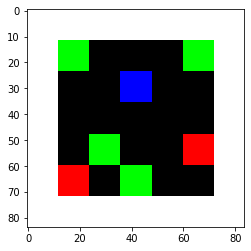

In [5]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=5)

## 네트워크 만들기

In [6]:
class Qnetwork():
    def __init__(self,h_size):
        # 네트워크는 게임으로부터 하나의 프레임을 받아 이를 배열로 만든다. (flattening)
        # 그 다음 배열의 크기를 재조절하고, 4개의 합성곱 계층을 거쳐 처리한다.
        self.scalarInput =  tf.placeholder(shape=[None,21168],
                                           dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,
                                  shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        # 마지막 합성곱 계층에서 출력값을 취한 후
        # 이를 어드밴티지 스트림과 가치 스트림으로 나눔
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        # 최종 Q값을 얻기 위해 어드밴티지 스트림과 가치 스트림을 조합함
        self.Qout = self.Value + tf.subtract(self.Advantage,
                                             tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        
        # 타깃 Q값과 예측 Q값의 차의 제곱합을 구하면서 비용을 얻음
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

## 경험 리플레이

In [7]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [8]:
# 게임의 프레임 크기 재조절
def processState(states):
    return np.reshape(states,[21168])

In [9]:
# 1차 네트워크의 매개변수에 맞춰서 타깃 네트워크의 매개변수를 업데이트해줌
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

## 네트워크 학습

In [10]:
batch_size = 32 # 학습 단계에서 사용할 경험 배치 수
update_freq = 4 # 학습 단계 업데이트 빈도
y = .99 # 타깃 Q에 대한 discount factor 
startE = 1 # 랜덤한 액션을 선택할 확률
endE = 0.1 # 랜덤한 액션을 끝낼 확률
annealing_steps = 10000. # startE에서 endE로 줄어드는 데 필요한 학습 단계 수
num_episodes = 10000 # 네트워크를 학습시키기 위한 게임 환경 에피소드 수
pre_train_steps = 10000 # 학습 시작 전 랜덤 액션의 단계 수
max_epLength = 50 # 허용되는 최대 에피소드 길이
load_model = False # 저장된 모델을 로드할지 여부
path = "./dqn" # 모델을 저장할 경로
h_size = 512 # 어드밴티지/가치스트림으로 분리되기 전 마지막 합성곱 계층 크기
tau = 0.001 # 타깃 네트워크를 제 1 네트워크로 업데이트하는 비율

In [11]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size) # 제 1 네트워크 - 액션 선택
targetQN = Qnetwork(h_size) # 제 2 네트워크 - 타깃 Q값 생성

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

# 랜덤 액션이 감소하는 비율 설정
e = startE
stepDrop = (startE - endE)/annealing_steps

# 보상의 총계와 에피소드별 단계 수를 담을 리스트
jList = []
rList = []
total_steps = 0

# 모델 저장할 경로 생성
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        # 환경을 리셋하고 첫번째 새로운 관찰을 얻는다.
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        # The Q-Network
        # 에이전트가 블록에 도달하기까지 최대 50회 시도하고 종료
        while j < max_epLength: 
            j+=1
            
            # Q 네트워크에서 그리디하게 액션 선택 (e의 확률로 랜덤 선택)
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,
                             feed_dict={mainQN.scalarInput:[s]})[0]
            
            # 액션을 선택함으로써 다음 state, reward, done
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            # 에피소드 버퍼에 경험 넣어줌
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            # total step이 pre_train_step보다 크면
            if total_steps > pre_train_steps:
                # e가 endE보다 크면
                if e > endE:
                    e -= stepDrop
                
                # targetQ 업데이트 해주기
                if total_steps % (update_freq) == 0:
                    # 경험에서 랜덤하게 배치 하나 샘플링 
                    trainBatch = myBuffer.sample(batch_size) 
                    
                    # 타깃 Q값에 대해 더블 DQN 업데이트 수행
                    Q1 = sess.run(mainQN.predict,
                                  feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,
                                  feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    
                    # 타깃값을 이용해 네트워크 업데이트
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),
                                   mainQN.targetQ:targetQ, 
                                   mainQN.actions:trainBatch[:,1]})
                    
                    # 타깃 네트워크가 제 1 네트워크와 동일하게 설정
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
                    
            rAll += r
            s = s1
            
            if d == True:
                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        
        # 정기적으로 모델 저장
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps, np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

/Users/ohyeji/anaconda3/envs/tf1/lib/python3.6/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Saved Model
500 2.7 1
1000 3.3 1
1500 1.8 1
2000 2.3 1
2500 1.2 1
3000 2.8 1
3500 2.8 1
4000 0.9 1
4500 1.2 1
5000 1.6 1
5500 3.4 1
6000 1.4 1
6500 1.0 1
7000 0.8 1
7500 2.6 1
8000 3.5 1
8500 2.8 1
9000 1.6 1
9500 1.1 1
10000 2.9 1
10500 2.3 0.9549999999999828
11000 1.4 0.9099999999999655
11500 1.1 0.8649999999999483
12000 2.4 0.819999999999931
12500 1.1 0.7749999999999138
13000 1.8 0.7299999999998965
13500 0.6 0.6849999999998793
14000 3.4 0.639999999999862
14500 1.8 0.5949999999998448
15000 1.5 0.5499999999998275
15500 2.6 0.5049999999998103
16000 3.3 0.4599999999998177
16500 4.2 0.41499999999982823
17000 2.2 0.36999999999983874
17500 3.6 0.32499999999984924
18000 5.2 0.27999999999985975
18500 2.6 0.23499999999986562
19000 2.0 0.18999999999986225
19500 3.0 0.14499999999985888
20000 1.7 0.09999999999985551
20500 2.4 0.09999999999985551
21000 2.0 0.09999999999985551
21500 1.8 0.09999999999985551
22000 3.0 0.09999999999985551
22500 2.1 0.09999999999985551
23000 4.2 0.09999999999985551
23

138500 22.5 0.09999999999985551
139000 24.3 0.09999999999985551
139500 21.3 0.09999999999985551
140000 22.4 0.09999999999985551
140500 20.2 0.09999999999985551
141000 21.7 0.09999999999985551
141500 24.3 0.09999999999985551
142000 24.7 0.09999999999985551
142500 21.1 0.09999999999985551
143000 21.4 0.09999999999985551
143500 22.0 0.09999999999985551
144000 23.7 0.09999999999985551
144500 21.6 0.09999999999985551
145000 22.8 0.09999999999985551
145500 22.6 0.09999999999985551
146000 19.1 0.09999999999985551
146500 23.4 0.09999999999985551
147000 22.5 0.09999999999985551
147500 24.3 0.09999999999985551
148000 18.6 0.09999999999985551
148500 22.1 0.09999999999985551
149000 23.3 0.09999999999985551
149500 20.7 0.09999999999985551
150000 22.1 0.09999999999985551
Saved Model
150500 22.7 0.09999999999985551
151000 21.9 0.09999999999985551
151500 21.4 0.09999999999985551
152000 24.7 0.09999999999985551
152500 23.4 0.09999999999985551
153000 21.5 0.09999999999985551
153500 23.7 0.09999999999985

266000 18.8 0.09999999999985551
266500 23.0 0.09999999999985551
267000 22.5 0.09999999999985551
267500 18.9 0.09999999999985551
268000 21.3 0.09999999999985551
268500 22.7 0.09999999999985551
269000 20.9 0.09999999999985551
269500 19.5 0.09999999999985551
270000 23.0 0.09999999999985551
270500 22.6 0.09999999999985551
271000 21.9 0.09999999999985551
271500 21.3 0.09999999999985551
272000 23.3 0.09999999999985551
272500 24.3 0.09999999999985551
273000 22.0 0.09999999999985551
273500 22.9 0.09999999999985551
274000 23.4 0.09999999999985551
274500 21.3 0.09999999999985551
275000 23.4 0.09999999999985551
275500 18.1 0.09999999999985551
276000 22.5 0.09999999999985551
276500 17.9 0.09999999999985551
277000 23.2 0.09999999999985551
277500 23.5 0.09999999999985551
278000 21.8 0.09999999999985551
278500 21.8 0.09999999999985551
279000 22.8 0.09999999999985551
279500 21.3 0.09999999999985551
280000 20.6 0.09999999999985551
280500 24.1 0.09999999999985551
281000 22.7 0.09999999999985551
281500 2

394000 23.8 0.09999999999985551
394500 22.6 0.09999999999985551
395000 23.6 0.09999999999985551
395500 23.8 0.09999999999985551
396000 21.2 0.09999999999985551
396500 21.0 0.09999999999985551
397000 20.2 0.09999999999985551
397500 25.3 0.09999999999985551
398000 20.2 0.09999999999985551
398500 24.1 0.09999999999985551
399000 25.0 0.09999999999985551
399500 23.5 0.09999999999985551
400000 21.9 0.09999999999985551
Saved Model
400500 20.1 0.09999999999985551
401000 22.9 0.09999999999985551
401500 22.7 0.09999999999985551
402000 23.2 0.09999999999985551
402500 24.3 0.09999999999985551
403000 21.3 0.09999999999985551
403500 22.4 0.09999999999985551
404000 23.6 0.09999999999985551
404500 19.6 0.09999999999985551
405000 21.8 0.09999999999985551
405500 22.4 0.09999999999985551
406000 22.5 0.09999999999985551
406500 22.0 0.09999999999985551
407000 20.2 0.09999999999985551
407500 22.9 0.09999999999985551
408000 21.8 0.09999999999985551
408500 23.5 0.09999999999985551
409000 22.6 0.09999999999985

## 학습 과정 시각화

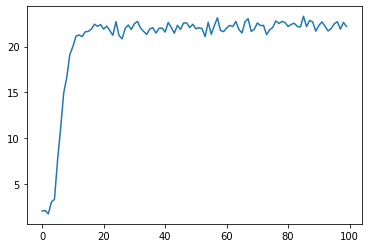

In [12]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)